<a href="https://colab.research.google.com/github/hajer-kouki/D-tection-de-la-somnolence-du-conducteur/blob/main/D%C3%A9tection_de_la_somnolence_du_conducteur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
data = os.listdir("/content/drive/MyDrive/Data/dataset_new/train")
data

['yawn', 'Closed', 'Open', 'no_yawn']

In [ ]:
def face_for_yawn(direc="/content/drive/MyDrive/Data/dataset_new/train", face_cas_path="/content/drive/MyDrive/Projet/haarcascade_frontalface_alt.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [ ]:
def get_data(dir_path="/content/drive/MyDrive/Data/dataset_new/train", face_cas="/content/drive/MyDrive/Projet/haarcascade_frontalface_alt.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data
data_train = get_data()

2
3


In [ ]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)
new_data = append_data()

0
1
2
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:
model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 71, 71, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 34, 34, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)      

In [ ]:
retVal = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/10
34/34 [==============================] - 292s 8s/step - loss: 1.2075 - accuracy: 0.4746 - val_loss: 0.7917 - val_accuracy: 0.6754
Epoch 2/10
34/34 [==============================] - 289s 9s/step - loss: 0.5179 - accuracy: 0.7989 - val_loss: 0.4223 - val_accuracy: 0.8531
Epoch 3/10
34/34 [==============================] - 283s 8s/step - loss: 0.3566 - accuracy: 0.8506 - val_loss: 0.4005 - val_accuracy: 0.8531
Epoch 4/10
34/34 [==============================] - 285s 8s/step - loss: 0.3056 - accuracy: 0.8806 - val_loss: 0.2574 - val_accuracy: 0.9211
Epoch 5/10
34/34 [==============================] - 282s 8s/step - loss: 0.2663 - accuracy: 0.8947 - val_loss: 0.2290 - val_accuracy: 0.9254
Epoch 6/10
34/34 [==============================] - 281s 8s/step - loss: 0.2122 - accuracy: 0.9201 - val_loss: 0.1713 - val_accuracy: 0.9320
Epoch 7/10
34/34 [==============================] - 283s 8s/step - loss: 0.1983 - accuracy: 0.9239 - val_loss: 0.1658 - val_accuracy: 0.9408
Epoch 8/10
34

In [ ]:
model.save('/content/drive/MyDrive/Projet/cnn.h5')

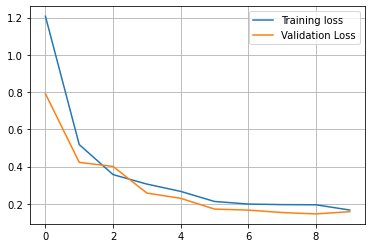

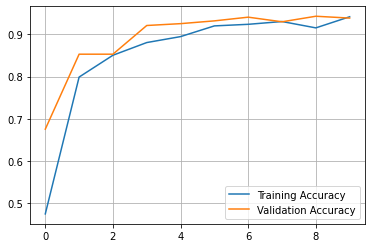

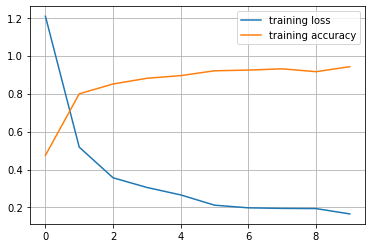

In [ ]:
plt.plot(retVal.history['loss'])
plt.plot(retVal.history['val_loss'])
plt.legend(['Training loss', 'Validation Loss'])
plt.grid(True)
plt.show()

plt.plot(retVal.history['accuracy']) 
plt.plot(retVal.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid(True)
plt.show()

plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

In [ ]:
prediction = model.predict(X_test)
prediction

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
from sklearn.metrics import classification_report
print(classification_report(y_test, np.round(prediction), target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.77      0.85      0.80        39
     no_yawn       0.77      0.56      0.65        36
      Closed       0.88      0.98      0.93       181
        Open       0.98      0.91      0.94       200

   micro avg       0.90      0.90      0.90       456
   macro avg       0.85      0.82      0.83       456
weighted avg       0.91      0.90      0.90       456
 samples avg       0.90      0.90      0.90       456



In [ ]:
IMG_SIZE = 145
def prepare(filepath, face_cas="/content/drive/MyDrive/Projet/haarcascade_frontalface_alt.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

3

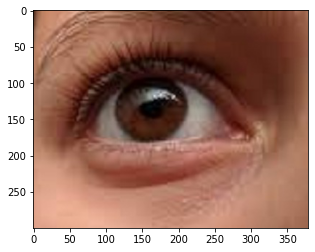

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/Data/dataset_new/train/Open/_100.jpg")])
plt.imshow(plt.imread("/content/drive/MyDrive/Data/dataset_new/train/Open/_100.jpg"))
np.argmax(prediction)

2

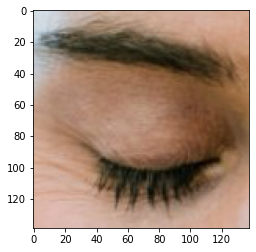

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/Data/dataset_new/train/Closed/_104.jpg")])
plt.imshow(plt.imread("/content/drive/MyDrive/Data/dataset_new/train/Closed/_104.jpg"))
np.argmax(prediction)

2

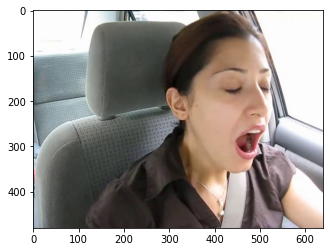

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/Data/dataset_new/train/yawn/1.jpg")])
plt.imshow(plt.imread("/content/drive/MyDrive/Data/dataset_new/train/yawn/1.jpg"))
np.argmax(prediction)